In [70]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Let's load the dataset from previos step - after feature engineering

## Setting proportions for Train, Test, Dev

As seen before (in EDA notebook) , the data outcomes in this dataset is balanced  (40% percent malignant vs 60% bening).
So we can straight continue to data splitting from here

In [71]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sb

df_mt = pd.read_pickle("IntermidiateData/4_FeatureEngeneering_Cancer_Data.pkl")
# Define the target and feature set
total_samples = df_mt.shape[0]

X = df_mt.drop(columns=['diagnosis'])
y = df_mt['diagnosis']

# Calculate percentages , with each set contains approximately the same percentage of samples of each target class as the complete set.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, shuffle=True,test_size=0.12, random_state=5,stratify=y)
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, shuffle=True,test_size=0.15, random_state=8,stratify=y_temp)

# Calculate percentages
train_percent = (X_train.shape[0] / total_samples) * 100
dev_percent = (X_dev.shape[0] / total_samples) * 100
test_percent = (X_test.shape[0] / total_samples) * 100

# Output the sizes of each set in percentages pertaining equal number of outcomes in each set
print(f"Training set size: {train_percent:.2f}%  {X_train.shape[0]} samples")
print(f"Validation (Dev) set size: {dev_percent:.2f}%  {X_dev.shape[0]} samples")
print(f"Testing set size: {test_percent:.2f}% {X_test.shape[0]} samples")


Training set size: 74.69%  425 samples
Validation (Dev) set size: 13.18%  75 samples
Testing set size: 12.13% 69 samples


## Hyperparameter tuning for the models suitable for binary classification tasks with GridSearchCV and cross-validation

In [72]:
# Hyperparameter tuning for the models with GridSearchCV

from sklearn.model_selection import GridSearchCV ,KFold, StratifiedKFold , cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report, accuracy_score
import xgboost as xgb

results = []
names = []
best_params = []
models = []
# with k-fold cross validation
# most important scoring = 'recall' since we are interested in minimizing false negatives (i.e. interested in predicting positive class precisely)
# as we also interested in mazimizing true negatives we can use f1 score
def estimator_function(models_opt, X , y , scoring = 'f1', folds = 5):  
    
    for name, model, params in models_opt:
        print(name , model , params) 
        # with k-fold single training set is split into k smaller sets (folds) and then model is trained using k-1 of the 
        # folds as training data and the model is validated on the remaining part 
        # This approach cross-validates estimations and helps to avoid overfit by training repeatedly on different train subsets
        #kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        kfold = StratifiedKFold(n_splits=folds, random_state=42, shuffle=True)
        #use all available cores to speed up the process
        grid_search = GridSearchCV(model, params,cv = kfold, refit = True , scoring=scoring, verbose=0, n_jobs=-1)
        grid_search.fit(X, y)
        best_params.append(grid_search.best_params_)         
        results.append(grid_search.best_score_)
        names.append(name)
        models.append(grid_search.best_estimator_)
                
    return names, results , best_params , models


In [73]:
# Here we define the models to be used for binary classification of the data
# and parameters for hyperparameter tuning using GridSearchCV and k-fold cross validation
SVM_params = {'C':[0.001, 0.1, 1, 10, 100 , 200], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}   # support vector machine
RF_params = {'n_estimators':[10, 100, 1000], 'max_features':['sqrt', 'log2']}      
# RF_params = { 'max_depth':[3,5,10],             # random forest  
#               'n_estimators':[10,100,200],
#               'criterion' : ['gini', 'entropy', 'log_loss'],
#               'max_features':['sqrt', 'log2'],
#               'min_samples_leaf':[1,2,3],
#               'min_samples_split':[1,2,3]}
KNN_params = {'n_neighbors':[3, 5, 7, 9, 11], 'weights':['uniform', 'distance']}    # k-nearest neighbors
DTC_params = {'criterion':['entropy', 'gini'], 'max_depth':[10, 50, 100]}    # decision tree classifier 
LR_params = {'C':[0.001, 0.1, 1, 10, 100], 'penalty': ['l1','l2'], 'solver': ['lbfgs', 'liblinear'] }                                   # logistic regression  
#GB_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # gradient boosting classifier
#AdaBoostClassifier_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # AdaBoost classifier
XGBClassifier_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # XGBoost classifier

svm = SVC()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
lr = LogisticRegression()
#gbc = GradientBoostingClassifier()
#adac = AdaBoostClassifier()
xgboostc = xgb.XGBClassifier()
gnb = GaussianNB()

# Create a list of models to tune
models_to_tune = [
    ('SVM', svm, SVM_params),
    ('RF', rfc, RF_params),
    ('KNN', knn, KNN_params),
    ('DTC', dtc, DTC_params),
    ('LR', lr, LR_params),
    #('GB', gbc, GB_params),
    #('AdaBoostClassifier', adac, AdaBoostClassifier_params),
    ('XGBClassifier', xgboostc, XGBClassifier_params),
    ('GaussianNB', gnb, {})]
 

In [74]:
hyperparameters_scoring='f1' # 'f1'
names, results , best_params , models  = estimator_function(models_to_tune, X_train , y_train ,\
                                hyperparameters_scoring , 5 )

SVM SVC() {'C': [0.001, 0.1, 1, 10, 100, 200], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
RF RandomForestClassifier() {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}
KNN KNeighborsClassifier() {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
DTC DecisionTreeClassifier() {'criterion': ['entropy', 'gini'], 'max_depth': [10, 50, 100]}
LR LogisticRegression() {'C': [0.001, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}


/home/lmanov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lmanov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

XGBClassifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...) {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 1]}
GaussianNB GaussianNB() {}


## Assess models scores on predicting (on validation and test datasets) , summarize data from the hyperparameter tuning step and achieved scores  into the tables

In [75]:

hyperparameter_tuning_scores_df = pd.DataFrame()
model_params_df = pd.DataFrame()
model_objects_dict = {}

for name, cv_result , param , model    in zip(names, results, best_params , models):        
        # handle the results (cross-validation scores)        
        dict = {'Model': name, 'Score': cv_result.mean().round(3)}
        row = pd.DataFrame([dict])             
        # append the results to the hyperparameter_tuning_scores_df    
        hyperparameter_tuning_scores_df = pd.concat([hyperparameter_tuning_scores_df, row], axis=0)   
        # handle the best parameters from the grid search
        best_param_dict = {'Model': name, 'Best params': [param]}      
        # convert the dictionary to a DataFrame
        best_param_row = pd.DataFrame(best_param_dict)    
        # append the best parameters to the model_params_df
        model_params_df = pd.concat([model_params_df , best_param_row], axis=0)
        # store the model object in a dictionary for subsequent use
        model_objects_dict[name] = model

hyperparameter_tuning_scores_df.reset_index(drop=True, inplace=True)
hyperparameter_tuning_scores_df.set_index('Model', inplace=True)
hyperparameter_tuning_scores_df.sort_values(by='Score', ascending=False, inplace=True)
hyperparameter_tuning_scores_df.to_pickle('IntermidiateData/5_Hyperparameter_Tuning_Results.pkl')
model_params_df.set_index('Model', inplace=True)
model_params_df.to_pickle('IntermidiateData/5_Model_Best_Params.pkl')


In [76]:
display(f"Using {hyperparameters_scoring} scoring , the hyperparameter tuning results for the models are as follows")
display(hyperparameter_tuning_scores_df.sort_values(by='Score', ascending=False))
display(model_params_df)
#display(model_objects_dict)

'Using f1 scoring , the hyperparameter tuning results for the models are as follows'

,Score
Model,
SVM,0.939
XGBClassifier,0.939
LR,0.936
RF,0.935
KNN,0.915
GaussianNB,0.915
DTC,0.892


,Best params
Model,
SVM,"{'C': 1, 'kernel': 'linear'}"
RF,"{'max_features': 'sqrt', 'n_estimators': 1000}"
KNN,"{'n_neighbors': 5, 'weights': 'distance'}"
DTC,"{'criterion': 'entropy', 'max_depth': 50}"
LR,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}"
XGBClassifier,"{'learning_rate': 0.01, 'n_estimators': 500}"
GaussianNB,{}


In [77]:
# prepare code  measuring performance of the models
from sklearn import metrics

def classificationMetrics(y, yhat):
    res = {'Accuracy': metrics.accuracy_score(y,yhat),
           'Precision': metrics.precision_score(y,yhat),
           'Recall': metrics.recall_score(y,yhat),
           'F1': metrics.f1_score(y,yhat),
           'AUC': metrics.roc_auc_score(y,yhat)
          }
    return res

In [78]:
import matplotlib.pyplot as plt

def test_model(model , model_name, X , y, models_perfmance_df):    
    lrtest_pred = model.predict(X)    # model is a best estimator from GridSearchCV                       
    mod1_dict = {'Model': model_name}
    new_row = pd.DataFrame([{**mod1_dict, **classificationMetrics(y, lrtest_pred) }])
    models_perfmance_df = pd.concat([models_perfmance_df, new_row], ignore_index=True)    
    cm = confusion_matrix(y, lrtest_pred)      
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    disp.ax_.set_title(f"Confusion Matrix for {model_name}")
    plt.rcParams['figure.figsize'] = [4, 3]
    plt.tight_layout()
    plt.show()
    return models_perfmance_df

def validate_models(models_perfmance_df, X, y):
    # tests different models with best parameters from hyperparameter tuning and returns the performance metrics
    for model_name in model_params_df.index:    
        model_instance = model_objects_dict[model_name]      
        models_perfmance_df  = test_model(model_instance , model_name, X, y, models_perfmance_df)    

    models_perfmance_df.reset_index(drop=True, inplace=True)
    models_perfmance_df.set_index('Model', inplace=True)
    return models_perfmance_df

We want to reduce a number of false negatives without necessary reducing the number of false positives , as in medical classification model false negative errors are very costly.
Thus , to choose rigth model we will look for a model with high recall value (good at correctly identifying true positives) plus good accuracy (good at positive predictions in general) 
 Instead , cost of false positive is not as high and thus precision metrics is less important. 
 F1 - a harmonic mean of recall and precition is also a good metrics to consider.

SVC has best scores - highest accuracy , precision , F1 and recall , no overfitting

'Validation : models confusion matrixes:'

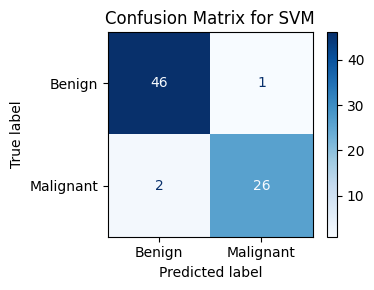

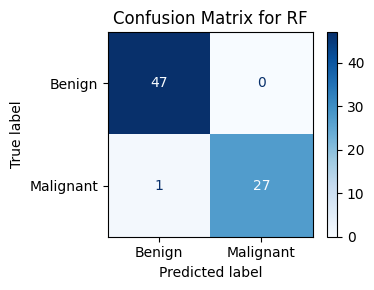

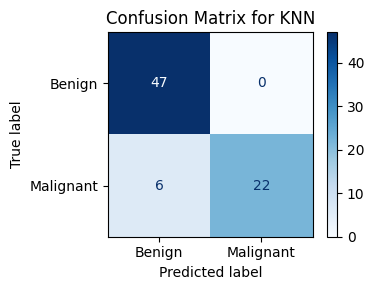

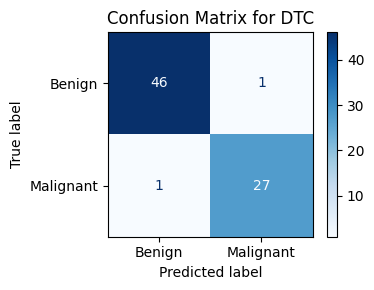

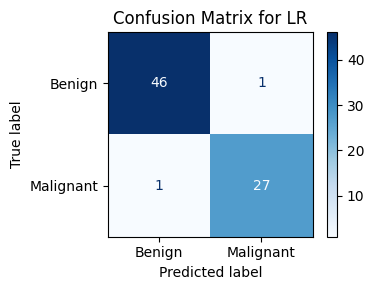

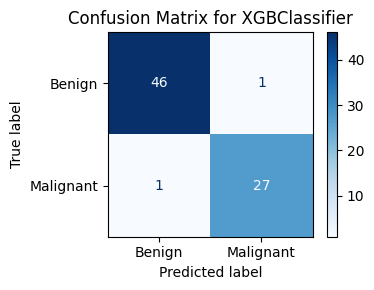

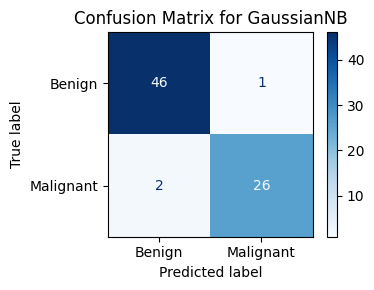

'Final evaluation : models confusion matrixes:'

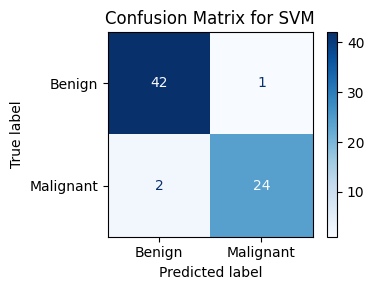

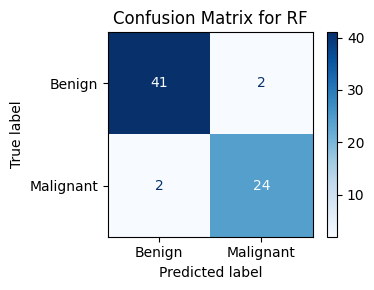

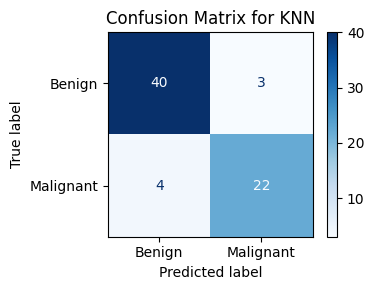

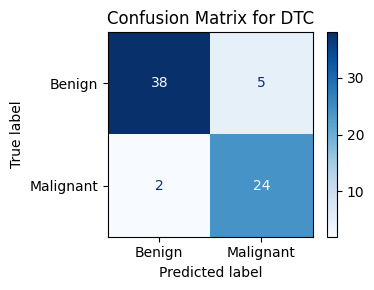

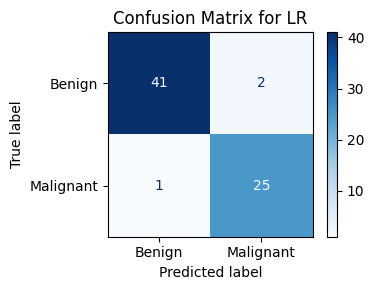

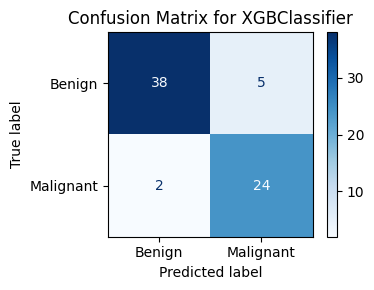

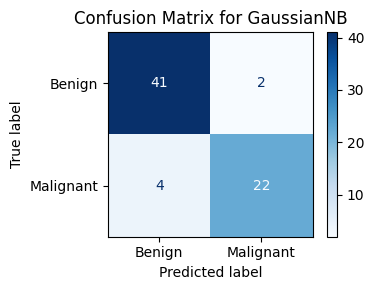

In [79]:

models_perfmance_df_val = pd.DataFrame()
display("Validation : models confusion matrixes:")
models_perfmance_df_val = validate_models(models_perfmance_df_val,X_dev, y_dev)

models_perfmance_df_test = pd.DataFrame()
display("Final evaluation : models confusion matrixes:")
models_perfmance_df_test = validate_models(models_perfmance_df_test,X_test, y_test)


In [80]:
validation_scoring = 'F1'
display(f"Validation set : models performance metrics with scoring {validation_scoring}")
display(models_perfmance_df_val.sort_values(by=validation_scoring, ascending=False).style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))
models_perfmance_df_val.to_excel('IntermidiateData/5_FinalValidationScores.xlsx')


display(f"Final evaluation : models performance metrics with scoring {validation_scoring}")
display(models_perfmance_df_test.sort_values(by=validation_scoring, ascending=False).style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))
models_perfmance_df_val.to_excel('IntermidiateData/5_FinalEvaluationScores.xlsx')

'Validation set : models performance metrics with scoring F1'

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
RF,0.986667,1.000000,0.964286,0.981818,0.982143
DTC,0.973333,0.964286,0.964286,0.964286,0.971505
LR,0.973333,0.964286,0.964286,0.964286,0.971505
XGBClassifier,0.973333,0.964286,0.964286,0.964286,0.971505
SVM,0.960000,0.962963,0.928571,0.945455,0.953647
GaussianNB,0.960000,0.962963,0.928571,0.945455,0.953647
KNN,0.920000,1.000000,0.785714,0.880000,0.892857


'Final evaluation : models performance metrics with scoring F1'

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
LR,0.956522,0.925926,0.961538,0.943396,0.957513
SVM,0.956522,0.960000,0.923077,0.941176,0.949911
RF,0.942029,0.923077,0.923077,0.923077,0.938283
GaussianNB,0.913043,0.916667,0.846154,0.880000,0.899821
DTC,0.898551,0.827586,0.923077,0.872727,0.903399
XGBClassifier,0.898551,0.827586,0.923077,0.872727,0.903399
KNN,0.898551,0.880000,0.846154,0.862745,0.888193


'SVM on scaled dev set'

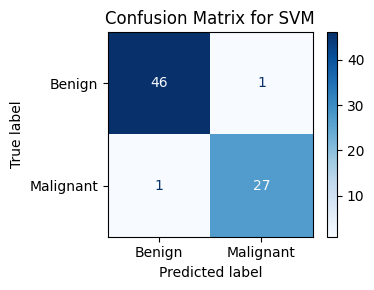

,Model,Accuracy,Precision,Recall,F1,AUC
0,SVM,0.973333,0.964286,0.964286,0.964286,0.971505


'SVM on scaled test set'

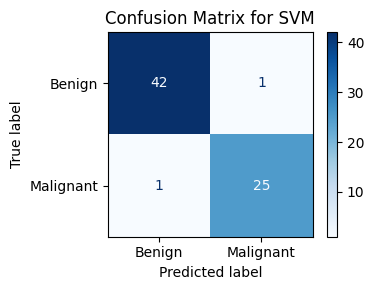

,Model,Accuracy,Precision,Recall,F1,AUC
0,SVM,0.971014,0.961538,0.961538,0.961538,0.969141


In [81]:
from sklearn.preprocessing import StandardScaler
SVC2= SVC()
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
grid_search = GridSearchCV(SVC2, SVM_params, cv = kfold , refit = True , scoring=hyperparameters_scoring, verbose=0, n_jobs=-1)       

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
grid_search.fit(X_train_scaled, y_train)

display("SVM on scaled dev set")
X_dev_scaled = scaler.fit_transform(X_dev)
classif_dev_df_scaled = pd.DataFrame()
classif_dev_df_scaled = test_model(grid_search.best_estimator_ , 'SVM', X_dev_scaled, y_dev, classif_dev_df_scaled)
display(classif_dev_df_scaled)

display("SVM on scaled test set")
X_test_scaled = scaler.fit_transform(X_test)
classif_test_df_scaled = pd.DataFrame()
classif_test_df_scaled = test_model(grid_search.best_estimator_ , 'SVM', X_test_scaled, y_test, classif_test_df_scaled)
display(classif_test_df_scaled)




Conclusion - scaling improves SVM performance